In [1]:
import os

import numpy as np
import pandas as pd
import pywt

from tsipy.correction import compute_exposure, correct_degradation, load_model
from tsipy.utils import (
    plot_signals,
    plot_signals_history,
    pprint,
    pprint_block,
)

In [2]:
def load_data_spm(file_name : str, directory="../data") -> pd.DataFrame:
    if f"{file_name}.h5" in os.listdir(directory):
        return pd.read_hdf(os.path.join(directory, f"{file_name}.h5"), "table")
    
    rows = []
    with open(file_name, "r") as f:
        i = 0
        while True:
            line = f.readline()
            line = line.strip().split()
            
            i += 1
            if not line:
                break
            
            if len(line) != 3:
                print(i, line)
                raise ValueError("Line {} does not have 3 entries: {}".format(i, line))
            
            rows.append(line)
        
    data = np.array(rows).astype(np.float)
    data = pd.DataFrame(data, columns=["t", "a", "b"])
    
    data.to_hdf(os.path.join(directory, f"{file_name}.h5"), "table", mode="w")
    return data

In [3]:
pprint_block("SPM Dataset", level=1)
data = load_data_spm("SpmRed", directory="../data")

# Treat zero-measurements as nans
data["a"][data["a"] == 0.0] = np.nan

# Add measurment at t = 0 for signal b
# data["b"][0] = data["a"][0]

# Compute exposure
e_a = compute_exposure(data["a"].values)
e_b = compute_exposure(data["b"].values)
max_e = max(np.max(e_a), np.max(e_b))
e_a /= max_e
e_b /= max_e
data["e_a"] = e_a
data["e_b"] = e_b

# Channel measurements
data_a = data[["t", "a", "e_a"]].dropna()
data_b = data[["t", "b", "e_b"]].dropna()

t_a_nn, t_b_nn = data_a["t"].values, data_b["t"].values
a_nn, b_nn = data_a["a"].values, data_b["b"].values
e_a_nn, e_b_nn = data_a["e_a"].values, data_b["e_b"].values

pprint("Signal", level=0)
pprint("- t_a_nn", t_a_nn.shape, level=1)
pprint("- a_nn", a_nn.shape, level=1)
pprint("- e_a_nn", e_a_nn.shape, level=1)

pprint("Signal", level=0)
pprint("- t_b_nn", t_b_nn.shape, level=1)
pprint("- b_nn", b_nn.shape, level=1)
pprint("- e_b_nn", e_b_nn.shape, level=1)

# Mutual measurements
pprint_block("Simultaneous measurements", level=1)
data_m = data[["t", "a", "b", "e_a", "e_b"]].dropna()
t_m = data_m["t"].values
a_m, b_m = data_m["a"].values, data_m["b"].values
e_a_m, e_b_m = data_m["e_a"].values, data_m["e_b"].values

pprint("Signal", level=0)
pprint("- t_m", t_m.shape, level=1)
pprint("- a_m", a_m.shape, level=1)
pprint("- e_a_m", e_a_m.shape, level=1)

pprint("Signal", level=0)
pprint("- t_m", t_m.shape, level=1)
pprint("- b_m", b_m.shape, level=1)
pprint("- e_b_m", e_b_m.shape, level=1)


    SPM Dataset                                   
---------------------------------------------------------------------------
Signal                                            
    - t_a_nn                                      (12385572,)
    - a_nn                                        (12385572,)
    - e_a_nn                                      (12385572,)
Signal                                            
    - t_b_nn                                      (711,)
    - b_nn                                        (711,)
    - e_b_nn                                      (711,)

    Simultaneous measurements                     
---------------------------------------------------------------------------
Signal                                            
    - t_m                                         (708,)
    - a_m                                         (708,)
    - e_a_m                                       (708,)
Signal                                            
    - t_m   

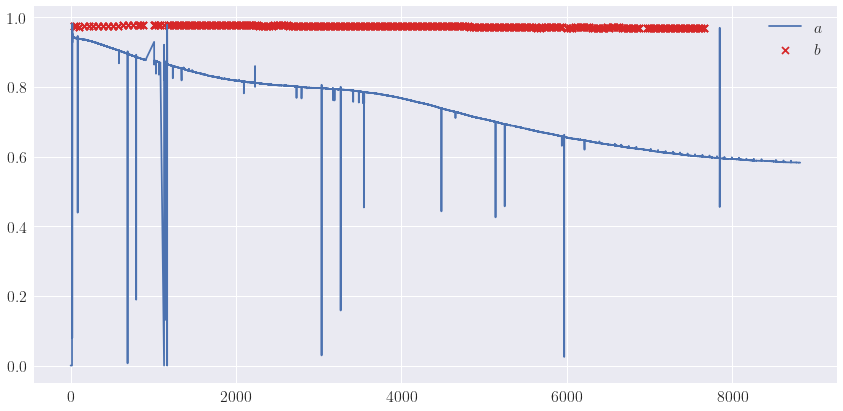

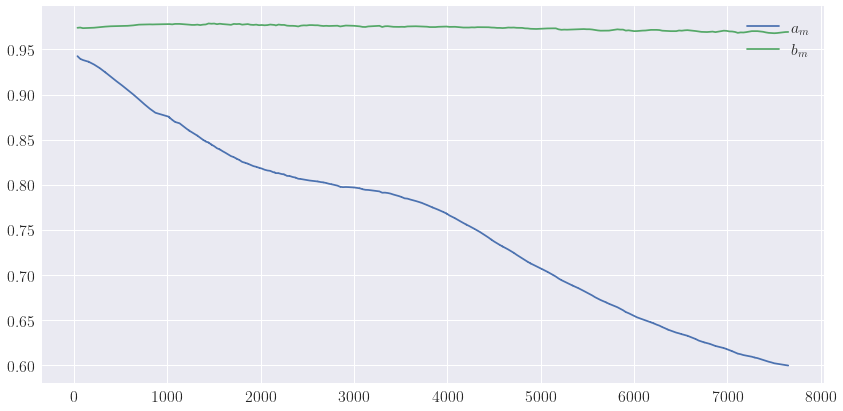

In [4]:
fig, ax = plot_signals([(t_a_nn, a_nn, "$a$", {})])
ax.scatter(t_b_nn, b_nn, label="$b$", c="tab:red")
ax.legend(loc="upper right")

fig, ax = plot_signals(
    [
        (t_m, a_m, "$a_m$", {}),
        (t_m, b_m, "$b_m$", {}),
    ],
    legend="upper right"
)


    Degradation Correction                        
---------------------------------------------------------------------------
    - Corrected in 3 iterations.                  
    - Corrected in 3 iterations.                  


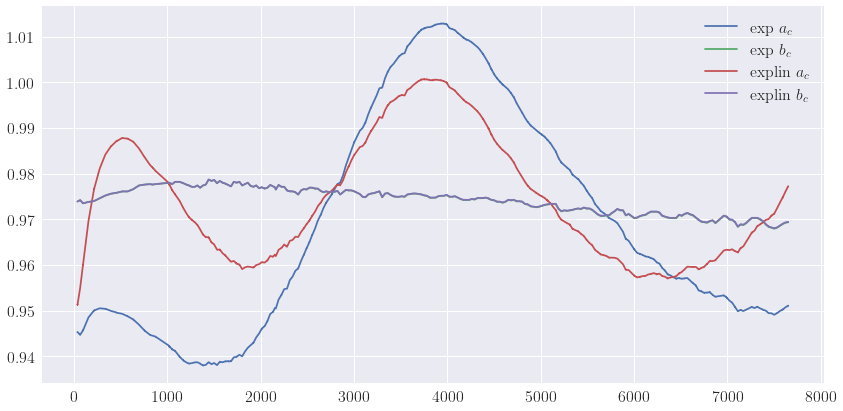

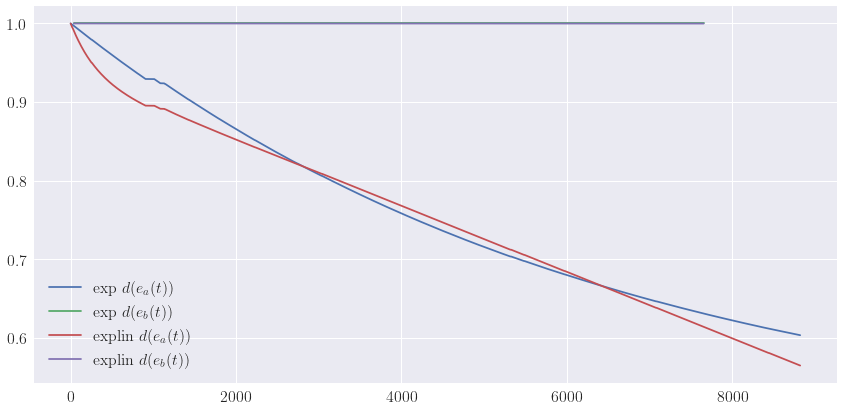

In [17]:
from collections import namedtuple
pprint_block("Degradation Correction", level=1)

Correction = namedtuple(
    "Correction", 
    [
        "a_m_c", 
        "b_m_c",
        "d_a_c",
        "d_b_c",
        "a_c_nn",
        "b_c_nn",
    ]
)
corrections = dict()
for model_name in ["exp", "explin"]:
    degradation_model = load_model(model_name)
    degradation_model.initial_fit(x_a=e_a_m, y_a=a_m, y_b=b_m)

    a_m_c, b_m_c, degradation_model, history = correct_degradation(
        t_m=t_m,
        a_m=a_m,
        e_a_m=e_a_m,
        b_m=b_m,
        e_b_m=e_b_m,
        model=degradation_model,
        verbose=True,
    )

    d_a_c = degradation_model(e_a_nn)
    d_b_c = degradation_model(e_b_nn)
    a_c_nn = np.divide(a_nn, d_a_c)
    b_c_nn = np.divide(b_nn, d_b_c)

    correction = Correction(
        a_m_c, b_m_c, d_a_c, d_b_c, a_c_nn, b_c_nn
    )
    corrections[model_name] = correction
    
signal_fourplets = []
for model_name in ["exp", "explin"]:
    correction = corrections[model_name]
    signal_fourplets.extend(
        [
            (t_m, correction.a_m_c, "{} $a_c$".format(model_name), {}),
            (t_m, correction.b_m_c, "{} $b_c$".format(model_name), {}),
        ]
    )
_ = plot_signals(signal_fourplets, legend="upper right")


signal_fourplets = []
for model_name in ["exp", "explin"]:
    correction = corrections[model_name]
    signal_fourplets.extend(
        [
            (t_a_nn, correction.d_a_c, "{} $d(e_a(t))$".format(model_name), {}),
            (t_b_nn, correction.d_b_c, "{} $d(e_b(t))$".format(model_name), {}),
        ]
    )
_ = plot_signals(signal_fourplets, legend="lower left")

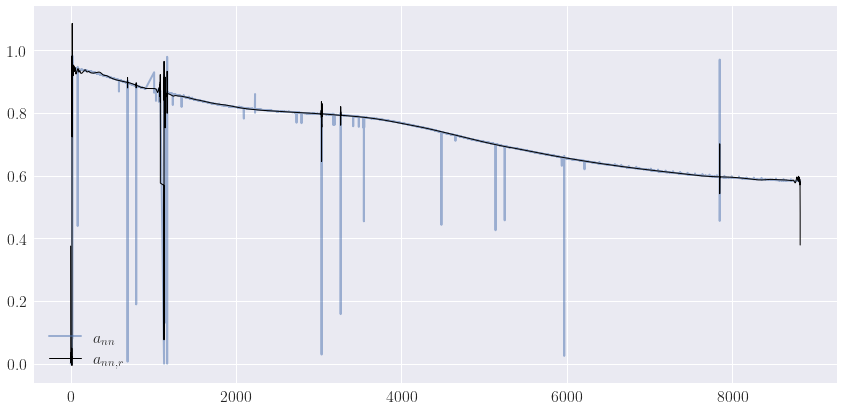

In [18]:
# Smoothing and outlier filtering

# Decomposition
c = pywt.wavedec(a_nn, wavelet="db5", mode="per")

# Denoising - Thresholding
thresh = 1.0 * np.nanmax(a_nn)
c[1:] = (pywt.threshold(coeff, value=thresh, mode="soft") for coeff in c[1:])

# Reconstruction
a_nn_r = pywt.waverec(c, wavelet="db5", mode="per")
 
fig, ax = plot_signals([
    (t_a_nn, a_nn, "$a_{nn}$", {"lw": 2, "alpha": 0.5}), 
    (t_a_nn, a_nn_r, "$a_{nn, r}$", {"lw": 1, "c": "k"}), 
],
    legend="lower left"
)